# BPL_YEAST_AIR_Fedbatch - demo

Author: Jan Peter Axelsson

This notebook demonstrate yeast fedbatch cultivation. We look at impact of changes in the glucose feeding. We also take a look at tuning of the DO-control system. Both liquid- and gasphase are included in the model. The culture growth and metabolism are formulated in relation to to the cells respiratory capacity [1] as well as oxygen limitation in the reactor. The model is exapanded to describe also the gas phase as well as the culture heat production [2]. The model was derived mainly from continuous culture data but proved to capture dynamic aspects well of ethanol production and consumption [3]. Several cultivations where donw with ethnol control that facilatated high cell density cultivations [4]. 

Interaction with the compiled model as FMU is mainly through the simplified commands: par(), init(), newplot(), simu() etc. The last simulation is always available in the workspace and called 'sim_res'. The command describe() brings mainly up description infomration from the actual Modelica code from the FMU but is complemented with information given in the dedicated Python setup-file.

The idea is to demonstrate how simulations and varyiing conditions can provide some process insight that can support the experimetnal work. I hope that at the end of this session you are ready to formulate your own questions you want to address with simulations - and you can just go on in this notebook! Just press the field "+Code" in the upper left part of notebook interface and you get a new "cell" where you write your own code. You can copy and paste from cells above using ctrol-c and ctrl-p as usual and edit the cell. When your are ready to execute the cell just press the "play button" to the left in the cell or press shift-enter as in "ordinary" Jupyter notebooks.

After a session you may want to save your own notebook. That you can do on your Google Drive account and I refer to Colab instructions for how to do this. It is easy. 

Enjoy!

In [1]:
run -i BPL_YEAST_AIR_Fedbatch_DOcontrol_fmpy_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [36/2.54, 30/2.54]

## About the process model

We can get information about the process, liquid- and gas-phase by the command describe(). This command can also be used to bring up information about a specific variable or parameter. However, you should use describe() after a simulation to get the valued used during the simulation.

In [3]:
describe('culture'); print(); #describe('liquidphase'); print(); describe('gasphase')

Saccharomyces cerevisae - default parameters for strain H1022



The model of the process has parameters both for culture, gas_liquid_transfer, as well as feeding procedure. The paramters that are available for changes you find by the command disp() and you get a long list and you change by them by command par(). The model has even more parameters in the background but not made available for interaction. 

No processDiagram.png file in the FMU, but try the file on disk.


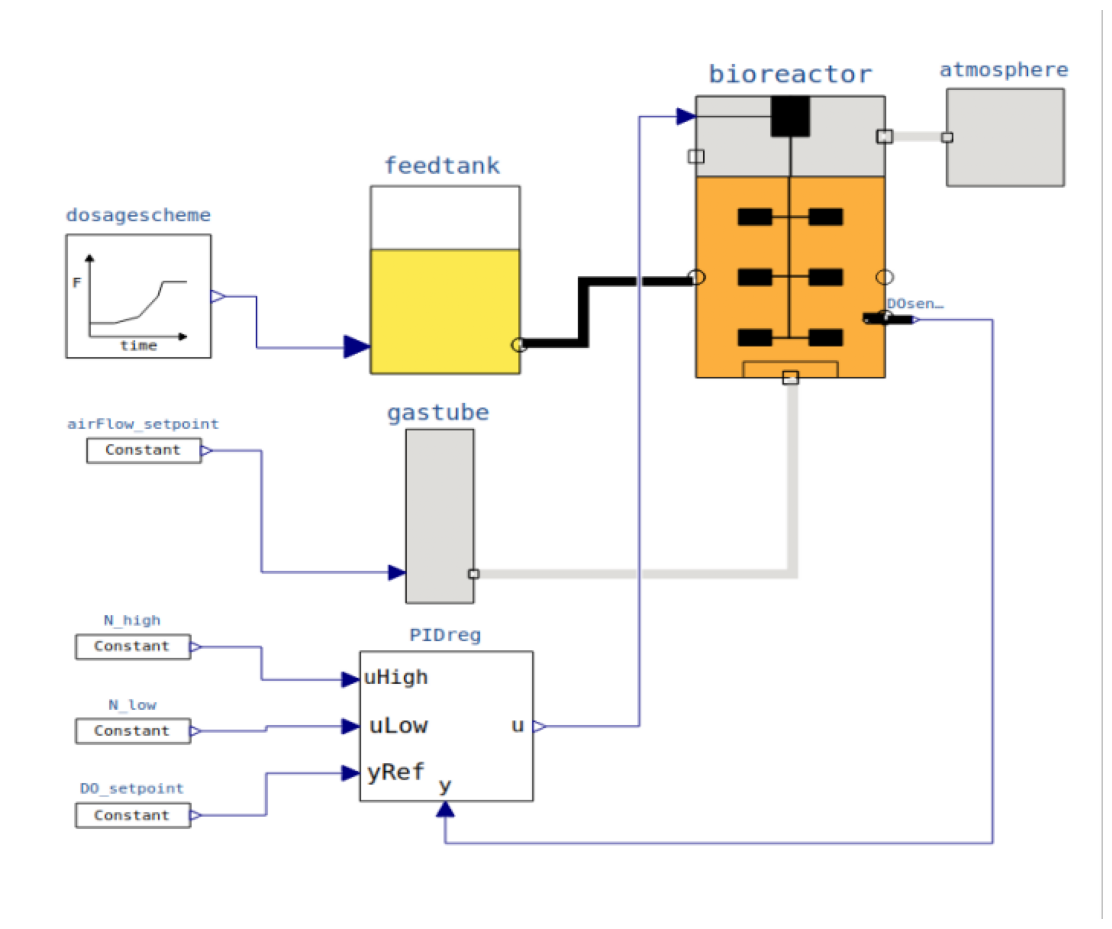

In [4]:
process_diagram()

## First simulations - adjusting start of substrate feeding

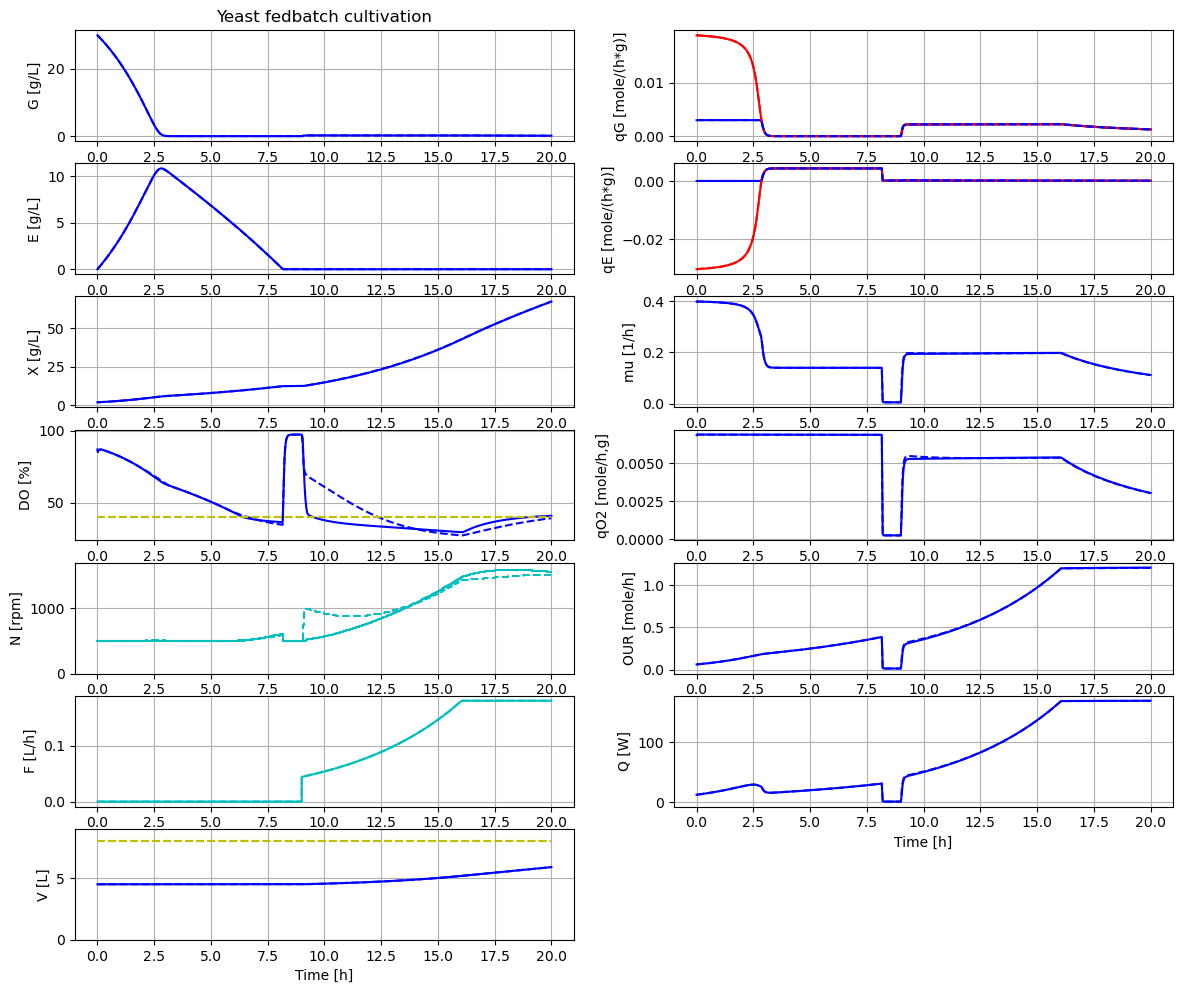

In [5]:
# Culture parameters and others at default values
par(qO2max=0.0069) 

# Process initial conditions
init(V_start=4.5, VG_start=4.5*30, VX_start=4.5*2, VE_start=4.5*0) 

# Feed profile
par(t_startExp=9, F_startExp=0.044, mu_feed=0.20, F_max=0.18)  

# DO-control parameters
#par(samplePeriod=1/60, K=10, Ti=0.5, I_0=500)   
par(K=10, Ti=0.5, I_start=0)   

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(Td=0)
simu(20)

par(Td=5.1)
simu(20)

In [6]:
start_values

{'bioreactor.V_start': 4.5,
 'bioreactor.m_start[1]': 9.0,
 'bioreactor.m_start[2]': 135.0,
 'bioreactor.m_start[3]': 0.0,
 'bioreactor.m_start[4]': 0.0067,
 'bioreactor.m_start[5]': 1.25,
 'bioreactor.V_tot': 8.0,
 'bioreactor.V_gas_start[1]': 2.4,
 'bioreactor.V_gas_start[2]': 0.6,
 'bioreactor.V_gas_start[3]': 0,
 'bioreactor.culture.qGmax': 0.02,
 'bioreactor.culture.Ks': 0.01,
 'bioreactor.culture.qO2max': 0.0069,
 'bioreactor.culture.KsO2': 1e-05,
 'bioreactor.gas_liquid_transfer.alpha_O2': 1.0,
 'feedtank.V_start': 50.0,
 'feedtank.c_in[2]': 500.0,
 'dosagescheme.F_start': 0.0,
 'dosagescheme.mu_feed': 0.2,
 'dosagescheme.t_startExp': 9,
 'dosagescheme.F_startExp': 0.044,
 'dosagescheme.F_max': 0.18,
 'airFlow_setpoint.value': 120.0,
 'DO_setpoint.value': 40.0,
 'DOsensor.x_start': 87.0,
 'PIDreg.K': 10,
 'PIDreg.Ti': 0.5,
 'PIDreg.Td': 5.1,
 'PIDreg.Nd': 3.0,
 'PIDreg.I_start': 0,
 'PIDreg.D_start': 0.0,
 'N_low.value': 500,
 'N_high.value': 2000}

Now we can get value of broth volume as well as the headspace and values are the last ones in the simulation

In [7]:
describe('bioreactor.V')

Reactor broth volume : 5.892 [ L ]


In [8]:
describe('bioreactor.V_gasphase')

Volume of the gas phase : 2.108 [ L ]


In [9]:
# Take a look at the parameters available to adjust the dosage scheme
disp('dosage', decimals=4)

F_start : 0.0
mu_feed : 0.2
t_startExp : 2.0
F_startExp : 0.12
F_max : 3.0


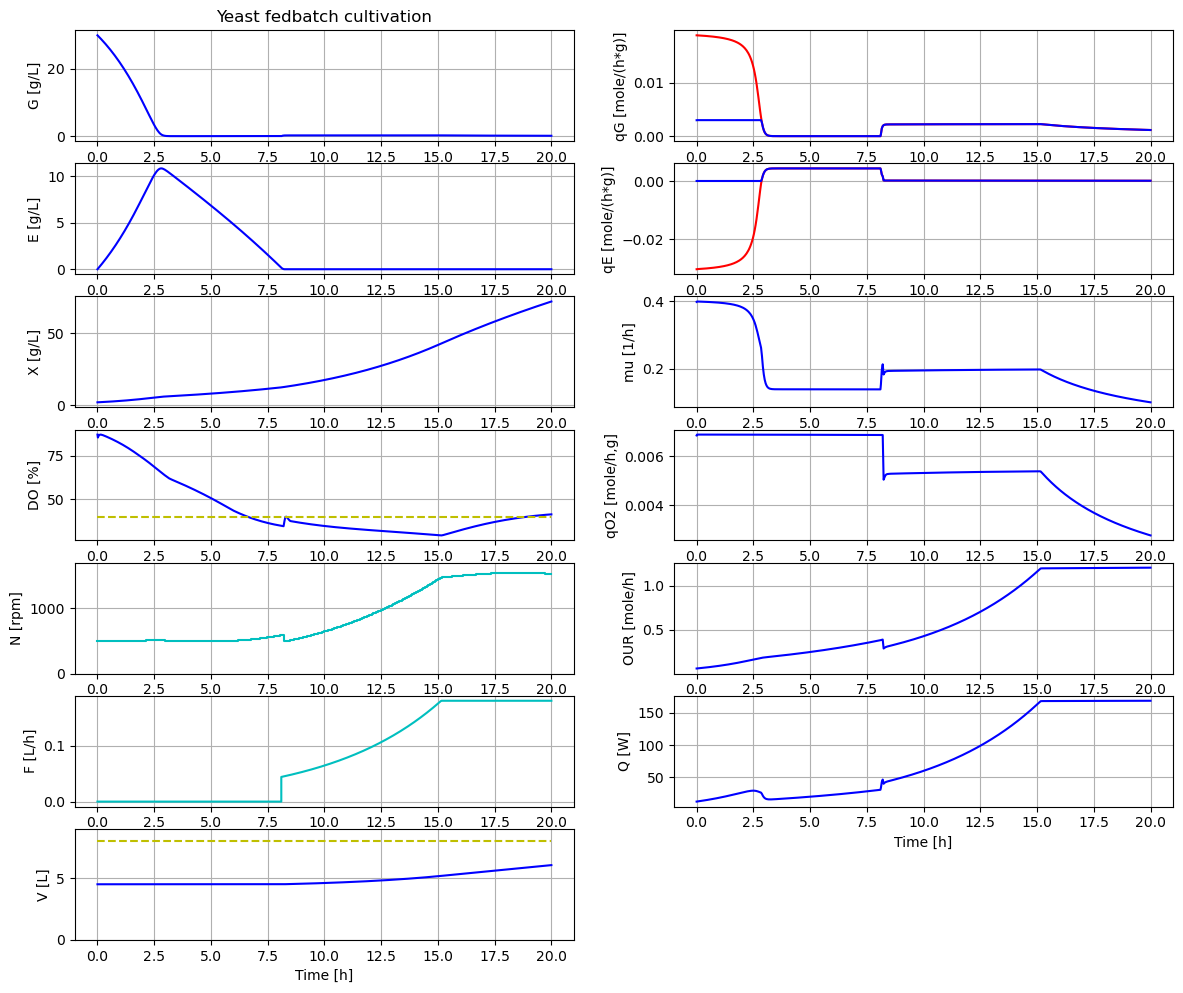

In [10]:
# Let us start the feeding just after the batch phase has ended and keep other parameters the same
par(t_startExp=8.1)

# Simulate and plot
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
simu(20)

The increase of DO to about 50 % at end of batch phase should be possible to detect easily. This simulation is more realistic and we use these settings from now on.

## DO-control  - tuning of PI-regulator parameters

Let us focus on the DO-control system and choose a more limited plotType. We study the impact of PI control parameters and see if we can decrease the control error without looing stability.

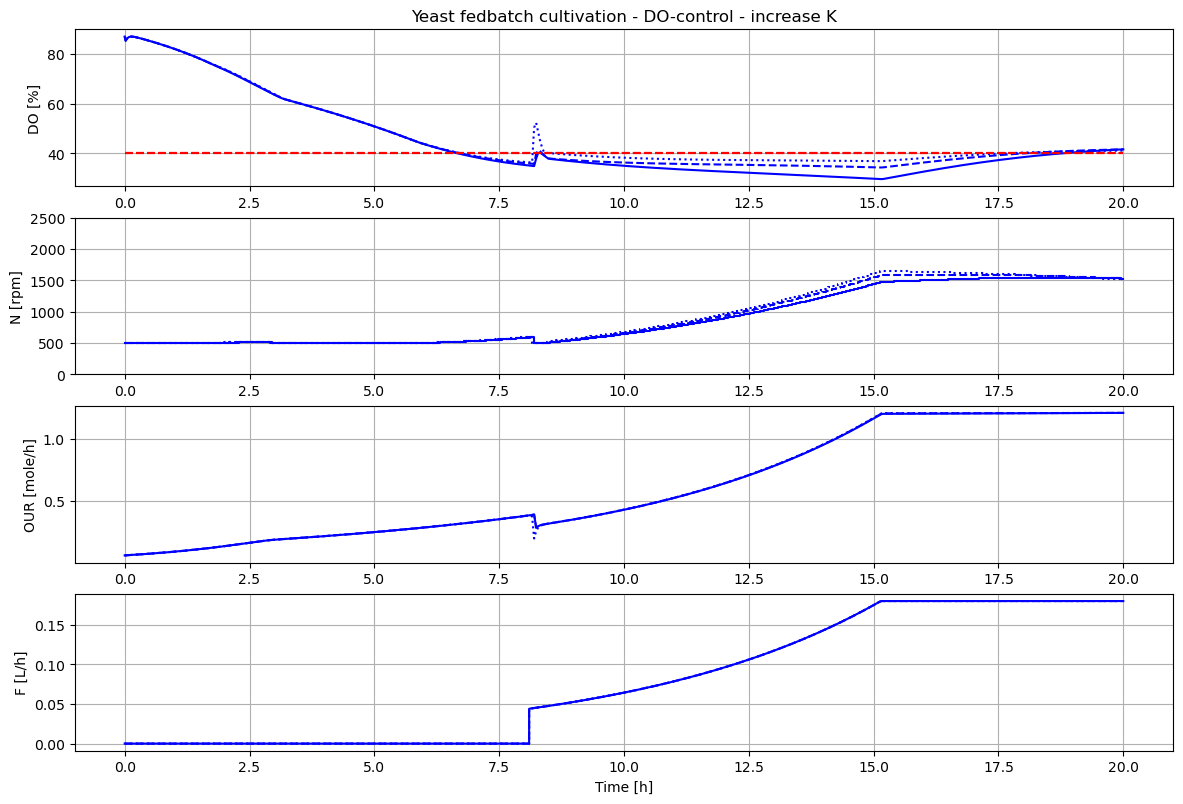

In [11]:
# Let us take a closer look at the DO-control system and try to make control error smaller by increaseing K
newplot(title='Yeast fedbatch cultivation - DO-control - increase K', plotType='Focus DO-control')
for value in [10, 20, 40]: par(K=value); simu(20)

# Reset K to the original value
par(K=10)

We see that by a higher control gain K the DO-control error get smaller and the stability of the control system is maintained.

In [12]:
diagrams

["ax1.plot(sim_res['time'],sim_res['DOsensor.out'],color='b',linestyle=linetype)",
 "ax1.plot(sim_res['time'],sim_res['DO_setpoint.out'],color='r',linestyle='--')",
 "ax2.step(sim_res['time'],sim_res['bioreactor.N'],color='b',linestyle=linetype)",
 'ax2.set_ylim([0,2500])',
 "ax3.plot(sim_res['time'],sim_res['bioreactor.m[1]']*sim_res['bioreactor.culture.qO2'],color='b',linestyle=linetype)",
 "ax4.plot(sim_res['time'],sim_res['bioreactor.inlet[1].F'],color='b',linestyle=linetype)"]

**Exercise** I leave for you to study the impact variation of the Ti-parameter. Just make a new cell below. Then copy and paste the cell above and change parameter to Ti.

## Sensitivity to changes in feed-profile

Now, let us focus on investigating impact of changes in the feed-profile. The goal is to increase the produced cell mass without accumulation of by-product ethanol. Simulation can bring some insight into how behaviour of the differen variables change when by-product is formed. This insight can help to interpret experimental results.

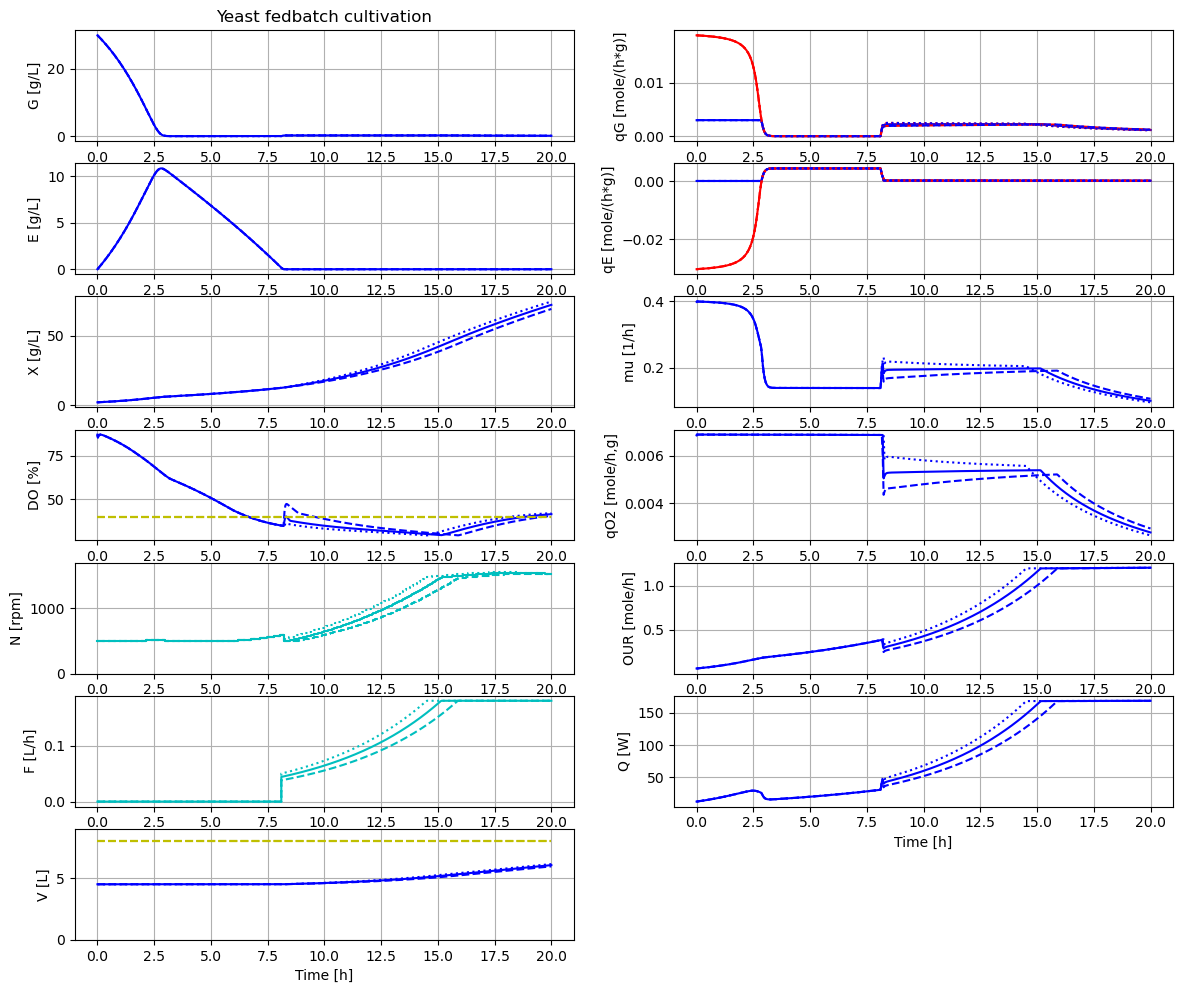

In [13]:
# Let us check the sensitivity to changes in the feed profile design
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
for value in [0.044, 0.038, 0.050]: par(F_startExp=value); simu(20)

The variation in F_start has an impact and we see that the actual growth rate during fedbatch phase do converge to the set growth rate of the feed, but i takes more than 5 hours.

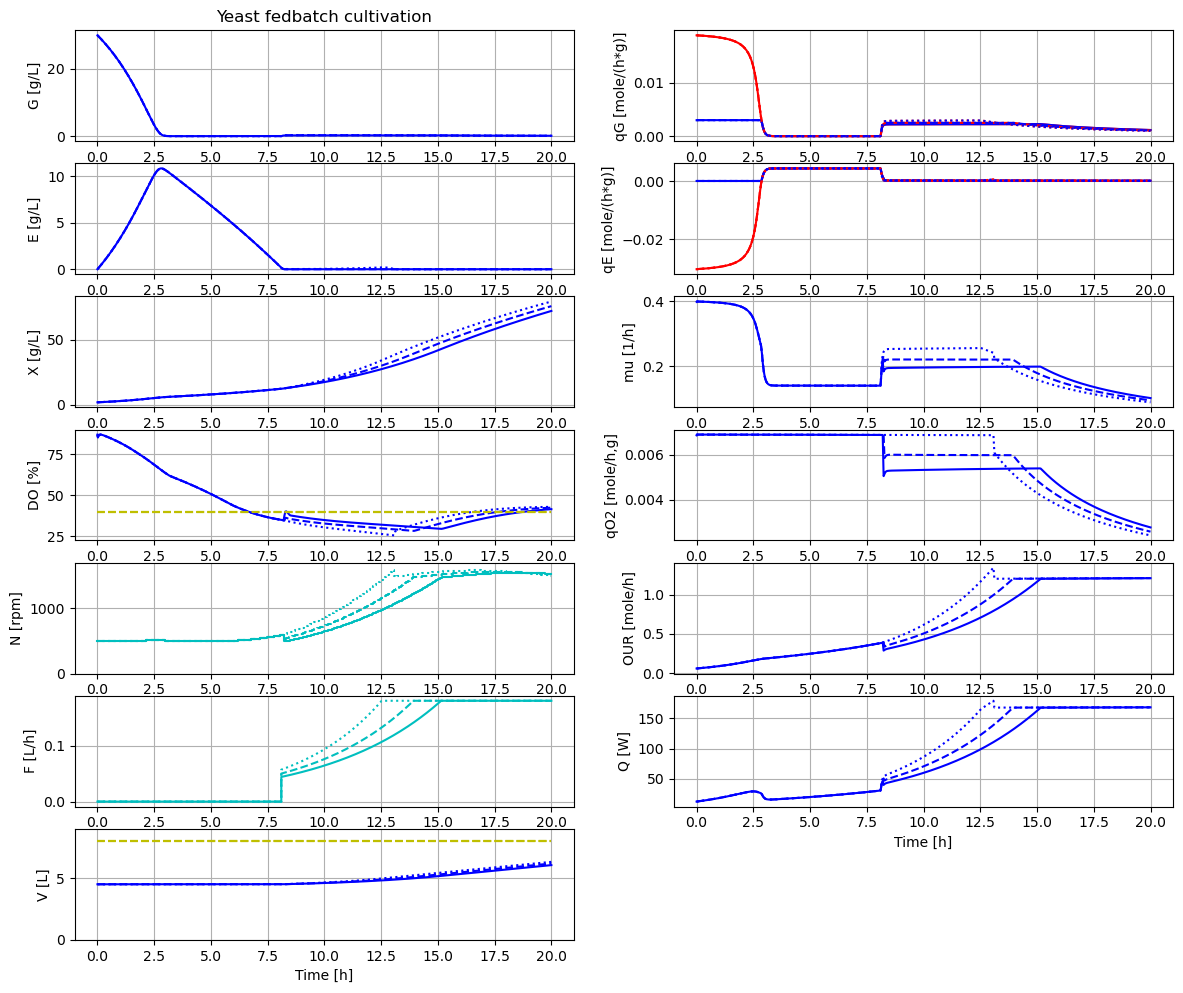

In [14]:
# Let us investigate a feedprofile that is closer to the maximal capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_startExp=0.044, mu_feed=0.20); simu(20)
par(F_startExp=0.050, mu_feed=0.22); simu(20)
par(F_startExp=0.057, mu_feed=0.26); simu(20)

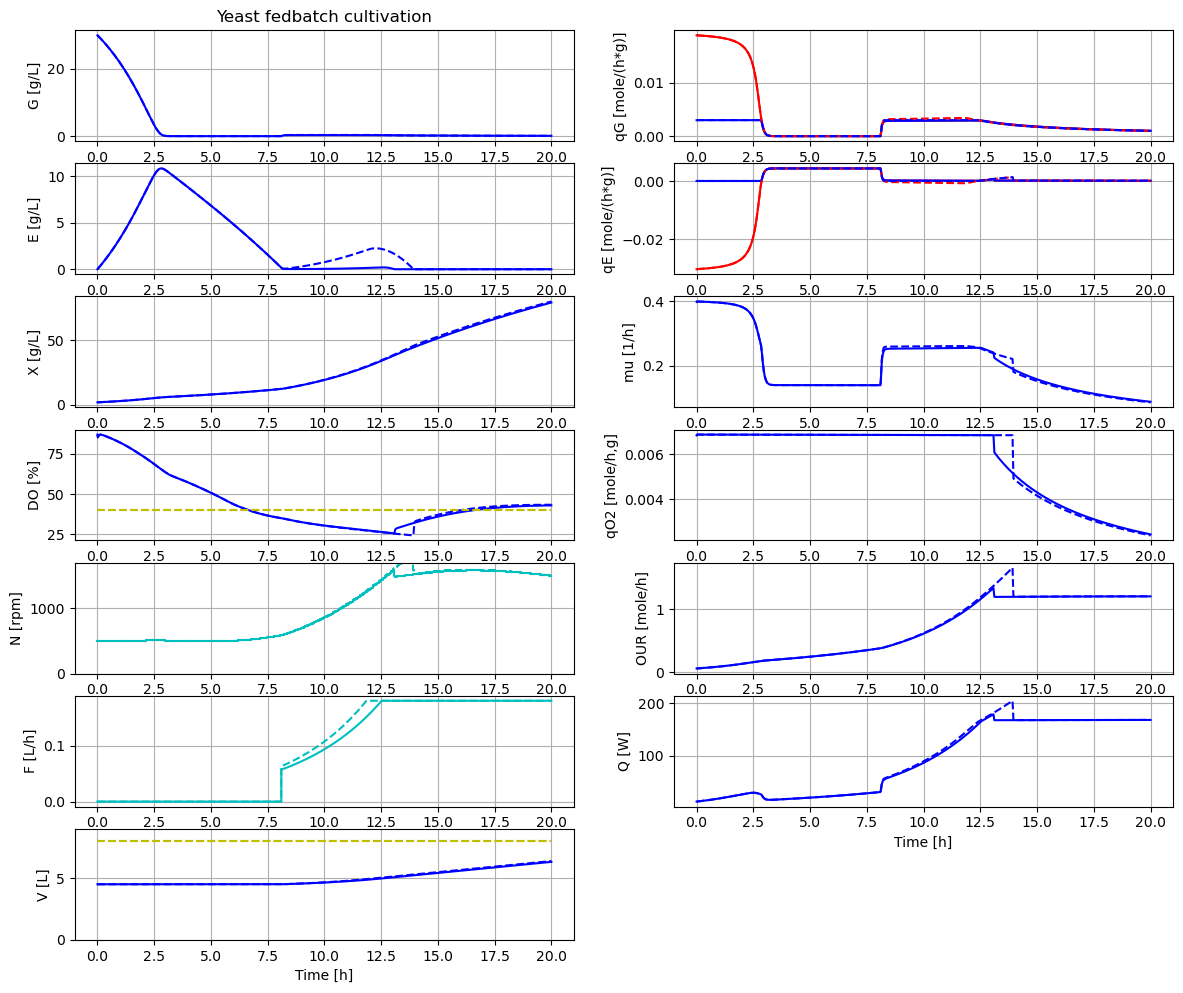

In [15]:
# And let us see what happens if the feedprofile exceed the culture capacity
newplot(title='Yeast fedbatch cultivation', plotType='Overview')
par(F_startExp=0.057, mu_feed=0.26); simu(20)
par(F_startExp=0.063, mu_feed=0.28); simu(20)
par(F_startExp=0.044, mu_feed=0.20)

Note that with the feedprofile that exceed culture respiratory capacity, ethanol is accumulated during time 8-12.5 hours. When the feedprofile then is constant from time 12.5 hours and on, then the accumulated ethanol is consumed over about an hour. This leads to a higher oxygen demand and heat production during this time. The specific cell growth rate is also slightly higher during this period.

**Exercise** You can investiate the impact of changing the maximal feedrate F_max. Make sure that the DO level do not get too low.

## Sensitivity to low dissolved oxygen levels
The detailed understanding of process dynamics at very low dissolved oxygen levels is not that well studied, to the authors knowledge. Here is a section on "Growth under oxygen limiation" in the original paper [1]. This model we use here. The idea is that the oxygen uptake is essentially described with a Monod-function with a parameter here denoted KsO2. At higher dissolved oxygen levels the uptake is saturated by the respiratory capacity and in our model denoted qO2max. Thus, at lower dissolved oxygen levels the respiration capacity is lowered and denoted here qO2lim and at sufficiently high dissolved oygen levels the qO2lim corresponds to qO2max. The value of qO2lim controls metabolism and growth. 

$$
qO2_{lim} = qO2^{max} {c[O2] \over KsO2 + c[O2]}
$$

The process dyanmics for variation of glucose feed rate around the respiratory capacity under well-aerated condtions are well described in [3]. It would be interesting to make similar studies at low dissolved oxygens levels. Also interesting to describe the impact of variation in the aeration during condition of a constant glucose supply to see the impact of ethanol production and consumption this way. 

During the time 1980-90 there was an interest to study the impact variation in dissolved oxygen in two-reactor setups [5]. In the smaller reactor dissolved oxygen level was low while higher in the larger reactor and the culture was circulated in the system at a rate related to typical mixing times in a large reactor. This experimental setup has been simulated with Bioprocess Library with focus on substrate gradients rather than oxygen gradients [6]. 




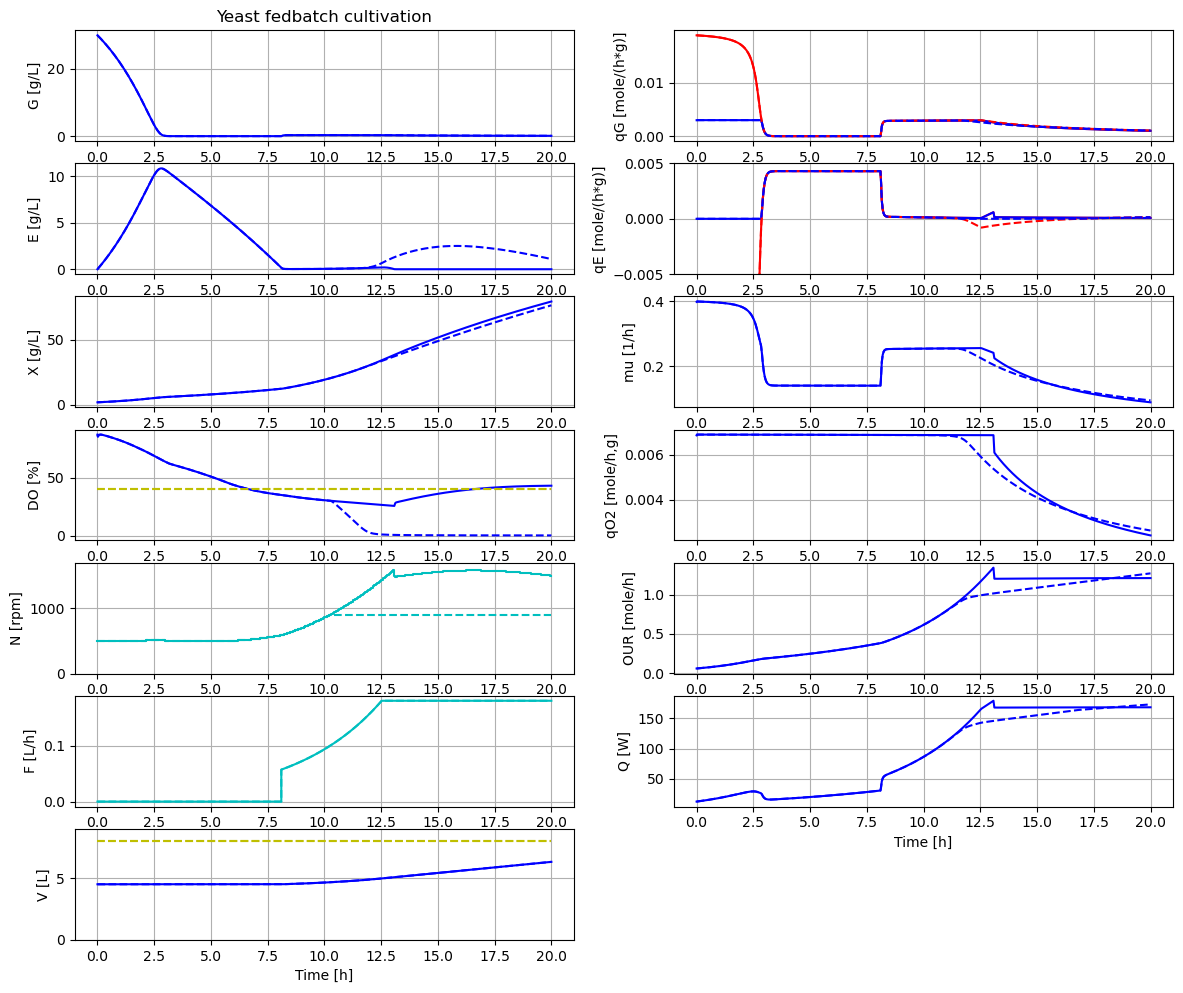

In [16]:
# Let us instead see what happens when the aeration read a limit in terms of stirrer speed.
newplot(title='Yeast fedbatch cultivation', plotType='Overview'); ax22.set_ylim([-0.005,0.005])
par(F_startExp=0.057, mu_feed=0.26); simu(20)
par(F_startExp=0.057, mu_feed=0.26, N_high=900); simu(20)
par(F_startExp=0.044, mu_feed=0.20, N_high=2000)

We see that after 10 hours the maximal stirrer speed is reached and that limits oxygen transfer and dissolved oxygen goes down. At about 12.5 hours the dissolved oxygen has come down to low levels that limits the specfic oxygen uptake rate and lower than the specific respiraotry capacity and we get ethanol production. 

## Summary
* We have first seen an overview diagram of a typical yeast fedbatch cultivation where the feed started about an hour after the batch phase was finished. A new simulation was made where the feed started directly after detection of lack of substrate.
* We also took a look at the DO-control system and saw that we could decrease the control error by increasing the PI-controller gain. Stability of the control system remained.
* Then we tested variations in the feed dosage scheme and investigated the possibilities to increae the production.
* We saw what happens if the feed dosage exceed the culture respiratory capacity and what to look for during the experimental work.
* We also saw what happens if the aeration is limiting and the tendency of the culture to produce ethanol. 

## References

[1] Sonnleitner, B. and O. Käppeli "Growth of *Sacharomyces cerevisiae* is controlled by its limited respiratory capacity: formulationa and verification of a hypothesis", Biotech. Bioeng., 1986.

[2] von Stockar, U., Gustafsson, L., Larsson, C., Marison, I., Tissot, P. and Gnaiger E. "Thermodynamic considerations in constructing energy balances for cellular growth", Biochimica et Biophysics Acta, vol 1183, p 221-240, 1993. 

[3] Axelsson, J. P. "Experimental techniques and data analysis to dtermine baker's yeast ethanol dynamics", Anal. Chim. Acta, vol 213, p 151-163, 1988.

[4] Axelsson, J. P., C. F. Mandenius, O. Holst, P. Hagander and B. Mattiasson "Experience in using an ethanol sensor to control molsses feed-rates in Baker's yeast production", Bioprocess Engineering, vol 3, p 1-9, 1988.

[5] Sweere, A. P. J., Matla, Y. A., Zandvliet, J., Luyben, K. C. A. M., Kossen, N. W. F., ”Experimental simulation of glucose fluctuation”, Appl. Microbial. Biotechnol., Vol 28, pg 109-‑115, 1988.

[6] Axelsson, J.P., “Investigation of effects of a hot-spot in bioprocess control”, oral presentation, Nordic Process Control Workshop, Sigtuna, Sweden, August 24-26, 2016.

## Appendix

In [17]:
disp('culture', decimals=5)

qGmax : 0.02
Ks : 0.001
qO2max : 0.0069
KsO2 : 1e-05


In [18]:
# Specific growth rate at the end of the last cultivation
describe('mu')

Cell specific growth rate variable : 0.094 [ None ]


In [19]:
disp('PIDreg', mode='long')

PIDreg.K : K : 0.1
PIDreg.Ti : Ti : 0.5
PIDreg.Td : Td : 0.0
PIDreg.Nd : Nd : 3.0
PIDreg.I_start : I_start : 0.0
PIDreg.D_start : D_start : 0.0


In [20]:
# List of components in the process setup and also a couple of other things like liquidphase and gasphase etc
describe('parts')

['airFlow_setpoint', 'atmosphere', 'bioreactor', 'bioreactor.culture', 'bioreactor.gas_liquid_transfer', 'DO_setpoint', 'dosagescheme', 'DOsensor', 'feedtank', 'gastube', 'N_high', 'N_low', 'PIDreg']


In [21]:
describe('MSL')

MSL: 4.1.0 - used components: RealInput, RealOutput, LimPID-components


In [22]:
system_info()


System information
 -OS: Linux
 -Python: 3.12.11
 -Scipy: not installed in the notebook
 -FMPy: 0.3.26
 -FMU by: OpenModelica Compiler OpenModelica 1.26.0~dev-200-gcb3254b
 -FMI: 2.0
 -Type: ME
 -Name: Fedbatch_DOcontrol
 -Generated: 2025-08-12T12:26:29Z
 -MSL: 4.1.0
 -Description: Bioprocess Library version 2.3.2 - prel
 -Interaction: FMU-explore for FMPy version 1.0.1


In [23]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 24.04.3 LTS
Release:	24.04
Codename:	noble
